In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import transformers
from transformers import LayoutLMForTokenClassification,\
    LayoutLMTokenizer, AdamW, LayoutLMv2Processor, LayoutLMv2ForTokenClassification
# from tensordict import TensorDict
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw, Image
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import logging
# from torchvision.transforms import PILToTensor
from torcheval.metrics.functional import multiclass_f1_score, \
    multiclass_accuracy

import os 
if 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset

In [5]:
logging.basicConfig(filename='logs/train.log', encoding='utf-8', level=logging.DEBUG)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

In [8]:
dataset = load_dataset("katanaml/cord", )

# dataset = load_dataset("darentang/sroie")

Repo card metadata block was not found. Setting CardData to empty.


## Creating PyTorch Datasets, DataLoader

In [9]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")


In [10]:
train_df = ImageLayoutDataset(dataset['train'], encode=True)

100%|██████████| 800/800 [00:38<00:00, 20.52it/s]


In [13]:
train_df[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

In [14]:
val_df = ImageLayoutDataset(dataset['validation'], encode=True)

100%|██████████| 100/100 [00:05<00:00, 19.89it/s]


In [15]:
train_dataloader = DataLoader(
    train_df,
    shuffle=True,
    batch_size= 2
)

validation_dataloader = DataLoader(
    val_df,
    shuffle= True,
    batch_size= 2
)

In [16]:
unique_rows = []
for row in dataset['train']['ner_tags']:
    unique_rows.append(np.unique(row))

In [17]:
unique_rows

[array([ 1,  3,  5, 11, 12, 13, 14, 22]),
 array([ 1,  3,  5,  7, 12, 13, 14, 22]),
 array([ 1,  3,  5, 13, 15, 16, 19, 20, 22]),
 array([ 1,  3,  5, 10, 12, 13, 14, 22]),
 array([ 1,  3,  5,  9, 13, 14, 15, 16, 22]),
 array([ 1,  3,  5, 12, 13, 14, 17, 21, 22]),
 array([ 1,  3,  5,  9, 13, 14, 15, 16, 22]),
 array([ 3,  5, 13, 14, 15, 16, 19, 22]),
 array([ 1,  3,  5,  9, 15, 16, 22]),
 array([ 1,  3,  5,  9, 13, 15, 16, 22]),
 array([ 1,  3,  5,  7, 13, 15, 16, 22]),
 array([ 1,  3,  5, 12, 13, 14, 22]),
 array([ 1,  3,  5, 11, 13, 14, 17, 19, 22]),
 array([ 1,  3,  5, 12, 13, 14, 22]),
 array([ 1,  3,  5,  9, 15, 16, 19, 22]),
 array([ 1,  3,  5, 12, 13, 14, 22]),
 array([ 3,  4,  5, 13, 17, 19, 22]),
 array([ 1,  3,  5, 13, 15, 16, 19, 20, 22]),
 array([ 1,  3,  5, 13, 14, 15, 16, 22]),
 array([ 1,  3,  5,  6,  7,  9, 11, 12, 13, 14, 22]),
 array([ 2,  3,  5, 13, 15, 22]),
 array([ 1,  3,  5,  9, 15, 16, 19, 22]),
 array([ 1,  3,  5,  9, 15, 16, 19, 22]),
 array([ 1,  3,  5,  7,  9

In [18]:
n_labels = np.unique(np.concatenate(unique_rows)).shape[0]

In [19]:
n_labels

23

## Importing model

In [20]:

model = LayoutLMForTokenClassification.from_pretrained(
    'microsoft/layoutlm-base-uncased',
    num_labels=n_labels
)
model.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

### Number of treinable / non-treinable parameters

In [21]:
print(f'''
    Model Info
    -----------------
    
    Treinable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}
    Non Treinable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad)}

''')


    Model Info
    -----------------
    
    Treinable params: 112645655
    Non Treinable params: 0




In [25]:
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10

#put the model in training model
logging.info('''
   Starting model training
   -----------------------       
''')
model.train()
history = {
   "train_accuracy": [],
   "train-f1": [],
   "validation-accuracy": [],
   "validation-f1": []
}

for epoch in tqdm(range(num_train_epochs)):
   logging.info(f"Epoch: {epoch}")
   train_f1 = []
   validation_f1 = []
   train_accuracy = []
   validation_accuracy = []
   for X in (train_dataloader):
      input_ids = X["input_ids"]\
         .to(device)\
         .squeeze()
      
      bbox = X["bbox"]\
         .to(device)\
         .squeeze()

      attention_mask = X["attention_mask"]\
         .to(device)\
         .squeeze()
      token_type_ids = X["token_type_ids"]\
         .to(device)\
         .squeeze()
      
      labels = X["labels"]\
         .to(device)\
         .squeeze()

      # image = X["image"]\
      #    .to(device)\
      #    .squeeze()

      # forward pass
      outputs = model(
         input_ids=input_ids, 
         bbox=bbox, 
         attention_mask=attention_mask, 
         token_type_ids=token_type_ids,
         labels=labels
      )
      
      loss = outputs.loss
      predictions = outputs.logits.argmax(-1)

      valid_outputs_mask = labels != -100

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
      
      acc = multiclass_accuracy(
         predictions[valid_outputs_mask],
         labels[valid_outputs_mask],
         num_classes=n_labels
      )

      # acc = multiclass_accuracy(
      #    predictions.reshape(-1),
      #    labels.reshape(-1),
      #    num_classes=n_labels
      # )

      f1 = multiclass_f1_score(
         predictions[valid_outputs_mask],
         labels[valid_outputs_mask],
         num_classes=n_labels
      )

      # f1 = multiclass_f1_score(
      #    predictions.reshape(-1),
      #    labels.reshape(-1),
      #    num_classes=n_labels
      # )

      train_accuracy.append(acc)
      train_f1.append(f1)

   with torch.no_grad():
      for X_validation in validation_dataloader:
         input_ids = X_validation["input_ids"]\
         .to(device)\
         .squeeze()
      
      bbox = X_validation["bbox"]\
         .to(device)\
         .squeeze()

      attention_mask = X_validation["attention_mask"]\
         .to(device)\
         .squeeze()
      token_type_ids = X_validation["token_type_ids"]\
         .to(device)\
         .squeeze()
      
      labels = X_validation["labels"]\
         .to(device)\
         .squeeze()

      # image = X_validation["image"]\
      #    .to(device)\
      #    .squeeze()

      # forward pass
      outputs = model(
         input_ids=input_ids, 
         bbox=bbox, 
         attention_mask=attention_mask, 
         token_type_ids=token_type_ids,
         labels=labels
      )

      loss = outputs.loss
      predictions = outputs.logits.argmax(-1)

      valid_outputs_mask = labels != -100

      correct = (predictions == labels)\
         [valid_outputs_mask]\
         .float()\
         .sum()
      
      acc = multiclass_accuracy(
         predictions[valid_outputs_mask],
         labels[valid_outputs_mask],
         num_classes=n_labels
      )

      # acc = multiclass_accuracy(
      #    predictions.reshape(-1),
      #    labels.reshape(-1),
      #    num_classes=n_labels
      # )

      f1 = multiclass_f1_score(
         predictions[valid_outputs_mask],
         labels[valid_outputs_mask],
         num_classes=n_labels
      )

      # f1 = multiclass_f1_score(
      #    predictions.reshape(-1),
      #    labels.reshape(-1),
      #    num_classes=n_labels
      # )

      validation_accuracy.append(acc)
      validation_f1.append(f1)

   avg_train_acc = torch.tensor(train_accuracy)\
      .mean()\
      .item()
   
   avg_train_f1 = torch.tensor(train_f1)\
      .mean()\
      .item()
   
   avg_val_acc = torch.tensor(validation_accuracy)\
      .mean()\
      .item()
   
   avg_val_f1 = torch.tensor(validation_f1)\
      .mean()\
      .item()


   history["train_accuracy"].append(avg_train_acc)
   history['train-f1'].append(avg_train_f1)
   history['validation-accuracy'].append(avg_val_acc)
   history['validation-f1'].append(avg_val_f1)

   logging.info(
      f'''
      End of epoch {epoch}
      ---------------------
      Training accuracy: {avg_train_acc}
      Tranining f1-score : {avg_train_f1}
      Validation accuracy: {avg_val_acc}
      Validation f1-score : {avg_val_f1}
      ''', 
   )


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:04<00:00, 24.42s/it]


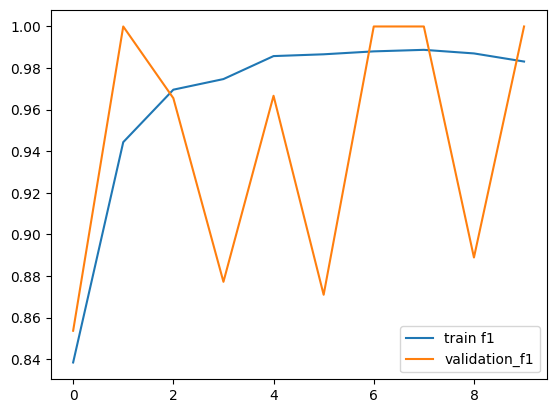

In [26]:
plt.plot(
    history['train-f1'],
    label = "train f1"    
)

plt.plot(
    history['validation-f1'],
    label = 'validation_f1'
)

plt.legend()

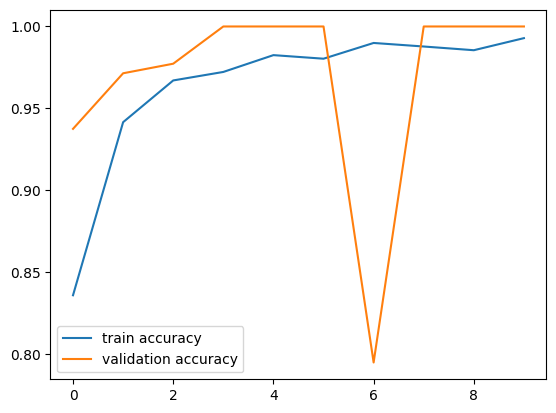

In [86]:
plt.plot(
    history['train_accuracy'],
    label = "train accuracy"    
)

plt.plot(
    history['validation-accuracy'],
    label = 'validation accuracy'
)

plt.legend()

## Training only classification layer

In [14]:

clf = LayoutLMForTokenClassification.from_pretrained(
    'microsoft/layoutlm-base-uncased',
    num_labels=n_labels
)
clf.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

In [18]:
for param in clf.layoutlm.parameters():
    param.requires_grad = False

In [19]:
print(f'''
    Model Info
    -----------------
    
    Treinable params: {sum(p.numel() for p in clf.parameters() if p.requires_grad)}
    Non Treinable params: {sum(p.numel() for p in clf.parameters() if not p.requires_grad)}

''')


    Model Info
    -----------------
    
    Treinable params: 17687
    Non Treinable params: 112627968




In [21]:
optimizer = AdamW(clf.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 50

#put the model in training model
logging.info('''
   Starting model training
   -----------------------       
''')
clf.train()
history_clf = {
   "train_accuracy": [],
   "train-f1": [],
   "validation-accuracy": [],
   "validation-f1": []
}

for epoch in tqdm(range(num_train_epochs)):
    logging.info(f"Epoch: {epoch}")
    train_f1 = []
    validation_f1 = []
    train_accuracy = []
    validation_accuracy = []
    for X in (train_dataloader):
        input_ids = X["input_ids"]\
            .to(device)\
            .squeeze()
        
        bbox = X["bbox"]\
            .to(device)\
            .squeeze()

        attention_mask = X["attention_mask"]\
            .to(device)\
            .squeeze()
        token_type_ids = X["token_type_ids"]\
            .to(device)\
            .squeeze()
        
        labels = X["labels"]\
            .to(device)\
            .squeeze()

        # image = X["image"]\
        #    .to(device)\
        #    .squeeze()

        # forward pass
        outputs = clf(
            input_ids=input_ids, 
            bbox=bbox, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids,
            labels=labels
        )
        
        loss = outputs.loss
        predictions = outputs.logits.argmax(-1)

        valid_outputs_mask = labels != -100

        # backward pass to get the gradients 
        loss.backward()

        # update
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        
        acc = multiclass_accuracy(
            predictions[valid_outputs_mask],
            labels[valid_outputs_mask],
            num_classes=n_labels
        )

        # acc = multiclass_accuracy(
        #    predictions.reshape(-1),
        #    labels.reshape(-1),
        #    num_classes=n_labels
        # )

        f1 = multiclass_f1_score(
            predictions[valid_outputs_mask],
            labels[valid_outputs_mask],
            num_classes=n_labels
        )

        # f1 = multiclass_f1_score(
        #    predictions.reshape(-1),
        #    labels.reshape(-1),
        #    num_classes=n_labels
        # )

        train_accuracy.append(acc)
        train_f1.append(f1)

    with torch.no_grad():
        for X_validation in validation_dataloader:
            input_ids = X_validation["input_ids"]\
            .to(device)\
            .squeeze()
        
        bbox = X_validation["bbox"]\
            .to(device)\
            .squeeze()

        attention_mask = X_validation["attention_mask"]\
            .to(device)\
            .squeeze()
        token_type_ids = X_validation["token_type_ids"]\
            .to(device)\
            .squeeze()
        
        labels = X_validation["labels"]\
            .to(device)\
            .squeeze()

        # image = X_validation["image"]\
        #    .to(device)\
        #    .squeeze()

        # forward pass
        outputs = clf(
            input_ids=input_ids, 
            bbox=bbox, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids,
            labels=labels
        )

        loss = outputs.loss
        predictions = outputs.logits.argmax(-1)

        valid_outputs_mask = labels != -100

        correct = (predictions == labels)\
            [valid_outputs_mask]\
            .float()\
            .sum()
        
        acc = multiclass_accuracy(
            predictions[valid_outputs_mask],
            labels[valid_outputs_mask],
            num_classes=n_labels
        )

        # acc = multiclass_accuracy(
        #    predictions.reshape(-1),
        #    labels.reshape(-1),
        #    num_classes=n_labels
        # )

        f1 = multiclass_f1_score(
            predictions[valid_outputs_mask],
            labels[valid_outputs_mask],
            num_classes=n_labels
        )

        # f1 = multiclass_f1_score(
        #    predictions.reshape(-1),
        #    labels.reshape(-1),
        #    num_classes=n_labels
        # )

        validation_accuracy.append(acc)
        validation_f1.append(f1)

    avg_train_acc = torch.tensor(train_accuracy)\
        .mean()\
        .item()
    
    avg_train_f1 = torch.tensor(train_f1)\
        .mean()\
        .item()
    
    avg_val_acc = torch.tensor(validation_accuracy)\
        .mean()\
        .item()
    
    avg_val_f1 = torch.tensor(validation_f1)\
        .mean()\
        .item()


    history_clf["train_accuracy"].append(avg_train_acc)
    history_clf['train-f1'].append(avg_train_f1)
    history_clf['validation-accuracy'].append(avg_val_acc)
    history_clf['validation-f1'].append(avg_val_f1)

    logging.info(
        f'''
        End of epoch {epoch}
        ---------------------
        Training accuracy: {avg_train_acc}
        Tranining f1-score : {avg_train_f1}
        Validation accuracy: {avg_val_acc}
        Validation f1-score : {avg_val_f1}
        ''', 
    )


/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/50 [00:00<?, ?it/s]